# Data Exploration

This dataset consisits of 64x64 images captured by Sentinel-2A satellite and it has over 27000 images spread across 10 classes. Originally the data consists of hyperspectral images with 13 spectral bands but we will be working with only RGB channels

The dataset is omposed of images taken from the Sentinel-2 satellite. It lists images of the earth's surface into 10 different land cover labels. 

In [1]:
# importing libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
dataset = "./dataset"
labels = os.listdir(dataset)
labels

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

These are the 10 classes of land cover in the dataset.

### Plotting class distributions of dataset

Text(0.5, 1.0, 'EUROSAT Class Distribution')

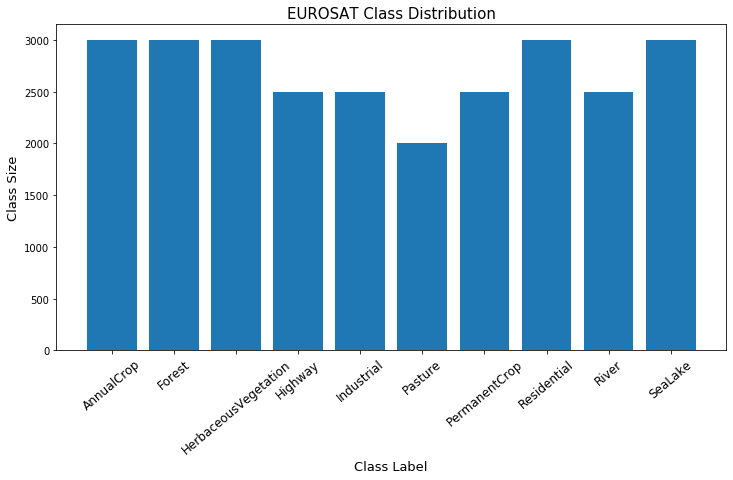

In [5]:
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(dataset, l)))

plt.figure(figsize=(12,6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('Class Label', fontsize=13)
plt.ylabel('Class Size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15)

The dataset is split into 10 classes of land cover. Each class varies in size, so we will have to stratify later on (when splitting the data into training, testing and validation sets).

### Preview of Different Classes

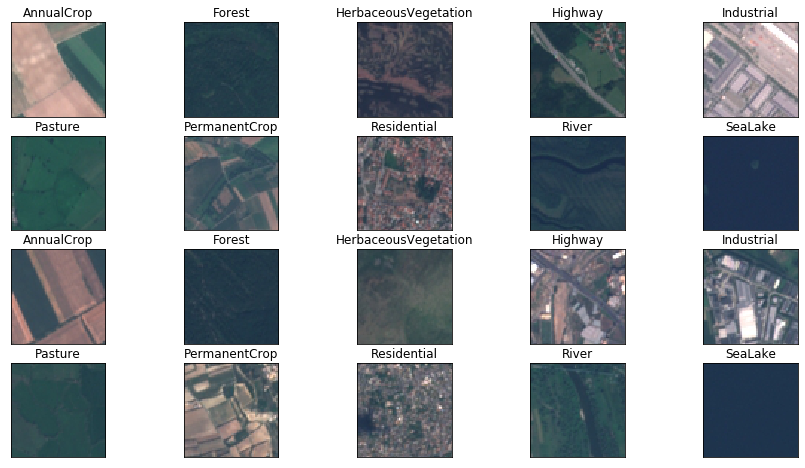

In [9]:
img_paths = [os.path.join(dataset, l, l+'_1000.jpg') for l in labels]

img_paths = img_paths + [os.path.join(dataset, l, l+'_2000.jpg') for l in labels]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('\\')[-2])

plot_sat_imgs(img_paths)

1. Some similarities and differences between the classes are observed.
2. Urban environments such as Highway, Residential, Industrial images contain structures and some roadways.
3. AnnualCrops and PermanentCrops both feature agricultural land cover, with straight lines dilineating different crop fields.
4. HerbaceaousVegetation, Pasture, and Forests feature natural land cover; Rivers also could be categorized as natural land cover as well, but may be easier to distinguish from the other natural classes.

NIR can be used to create an index, visualising the radiation that is present (or not present) in a picture. This dataset does not contain the NIR wavelength bands, so this option will not be explored. But it's worth pointing out that this classification task could be addressed in another way using NIR data.

# Data Preprocessing

We have performed a stratified shuffle-split using Scikit-learn to maintain class proportions. 30% of the dataset will be held for evaluation purposes. We will be loading my data into the Keras model using the ImageDataGenerator class. We will need the images to be in their own respective land cover directories.

After splitting the dataset, we will create some image augmentations using the generator and also denote a subset of the training data to be used as validation data during training.

In [2]:
# importing libraries
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'keras'